# Modelos Econometricos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

In [3]:
cd SIPPY-master/

/content/drive/MyDrive/Proyecto_Splra/SIPPY-master


In [ ]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

In [ ]:
!python setup.py install

## Carga de modulos necesarios

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 900
mpl.rcParams['font.family'] = 'serif'
import warnings
warnings.filterwarnings('ignore')
from scipy import linalg as la

from statsmodels.tools.eval_measures import rmse
from sklearn import preprocessing
from sklearn.metrics import r2_score

import sys
sys.path.append('/content/drive/MyDrive/Proyecto_Splra/Python')

from Sparse_Lra import *
from Lra_Modeling import *
from Sparse_Sys_Id import *

## Carga y procesamiento de los datos

In [10]:
# - FRED-MD load data
data = (pd.read_csv('/content/drive/MyDrive/Proyecto_Splra/Data/2022-01.csv').dropna(how='all'))

# 2. Extract transformation information
transform_m = data.iloc[0, 1:]
data = data.iloc[1:]

# 3. Extract the date as an index
data.index = pd.PeriodIndex(data.sasdate.tolist(), freq='M')
data.drop('sasdate', axis=1, inplace=True)

#data_t = data.apply(transform, axis=0,
 #                        transforms=transform_m)

# 3. Extract the date as an index
#data_t.index = pd.PeriodIndex(data.sasdate.tolist(), freq='M')
#data_t.drop('sasdate', axis=1, inplace=True)

In [11]:
data=data.dropna(how='any',axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1959-01 to 2021-12
Freq: M
Columns: 105 entries, RPI to INVEST
dtypes: float64(105)
memory usage: 626.1 KB


In [13]:
Var_orig = data[['TB3MS','RPI','INDPRO','S&P 500','BUSLOANS','CPIAUCSL','OILPRICEx','M2SL','UNRATE']]
Var_orig.columns=['TB3MS','RPI','INDPRO','SP 500','BUSLOANS','CPIAUCSL','OILPRICEx','M2SL','UNRATE']

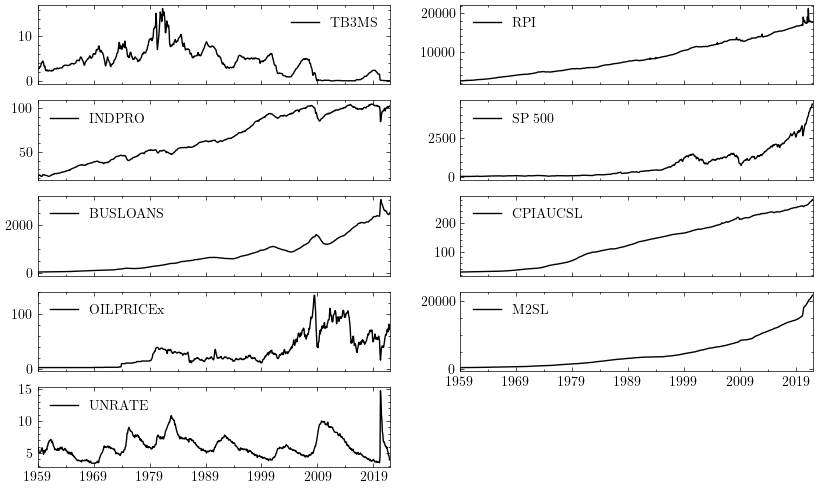

In [14]:
with plt.style.context(['science']):
    Var_orig.plot(figsize=(10, 6), subplots=True,layout=(5,2),color='k')
    #plt.savefig('var01.png')
    plt.show()

In [15]:
X=Var_orig.values.T
Xd=signal.detrend(X)
scaler = preprocessing.StandardScaler().fit(Xd.T)
Xs = scaler.transform(Xd.T)
df_scaled=pd.DataFrame(Xs,Var_orig.index,Var_orig.columns)

In [16]:
Xs.shape

(756, 9)

In [17]:
ntest=int(0.30*len(data))
train,test = df_scaled[:-ntest], df_scaled[-ntest:]
train.shape,test.shape

((530, 9), (226, 9))

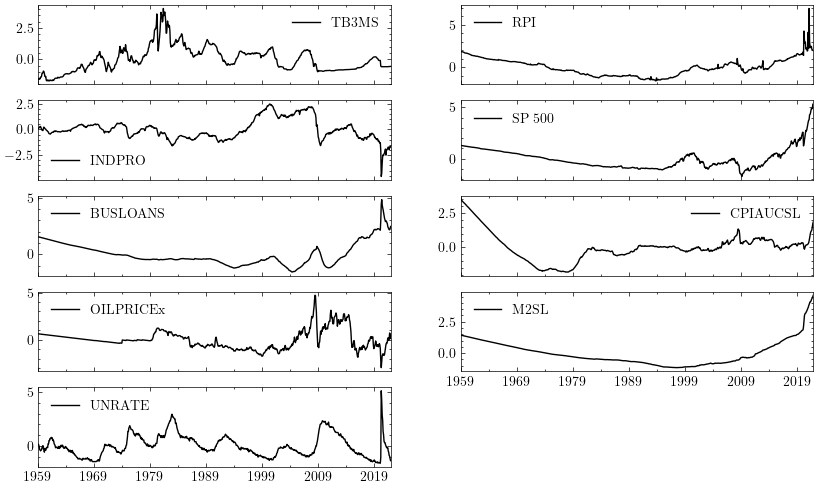

In [18]:
with plt.style.context(['science']):
    df_scaled.plot(figsize=(10, 6), subplots=True,layout=(5,2),color='k')
    #plt.savefig('var02.png')

    plt.show()

## SpLra

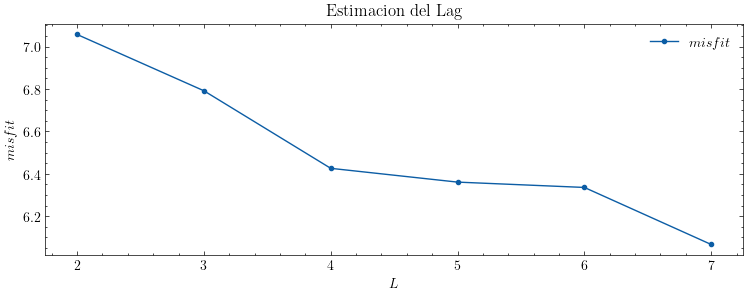

In [20]:
lag_est(train.values.T,8,8,x0=1,tol=1e-2,delta=1e-2)

In [21]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0=Sparse_lra_sysid(train.values.T,2,8, x0 = 1, tol=5e-2 , delta=5e-2)

In [22]:
M,fit

(6.997506678140034, 88.2463034981788)

In [23]:
wh.shape,Xs.shape

((9, 530), (756, 9))

In [26]:
sparsity_ss(sys_ss)

83.33333333333334

In [27]:
sys_ss.A

matrix([[0.        , 0.19837769],
        [1.        , 0.77328278]])

In [28]:
sys_tf

TransferFunction([[array([-0.07983009,  0.09879998,  0.        ]), array([0.08632125]), array([-0.56422357,  0.08880802,  0.40606188]), array([ 0.11339669, -0.04098819]), array([-0.0750763 , -0.39586545,  0.38593634]), array([-0.06949465,  0.38436899, -0.31255017]), array([ 0.05698886, -0.05399484,  0.        ]), array([-0.08134242,  0.        ,  0.        ])]], [[array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769]), array([ 1.        , -0.77328278, -0.19837769])]], 1)

In [29]:
t=np.arange(len(data))

In [31]:
t,y=cnt.forced_response(sys_ss,U=Xs[:,:-1].T,X0=x0)

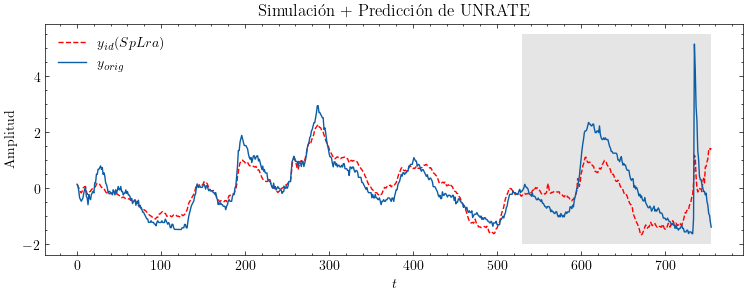

In [32]:
with plt.style.context(['science']):
    plt.figure(figsize=(9,3))
    plt.plot(t,y.T,'--',color='r',label='$y_{id}(SpLra)$')
    plt.plot(t,Xs[:,-1],label='$y_{orig}$')
    plt.xlabel('$t$')
    plt.ylabel('Amplitud')
    plt.title('Simulación + Predicción de UNRATE')
    plt.legend()

    ylim = plt.ylim()
    plt.fill_between(t[-ntest:], ylim[0], ylim[1], facecolor='k', alpha=0.1);
    #plt.savefig('var04.png')
    plt.show()

In [33]:
rmse(train.values.T,wh,axis=-1), rmse(Xs[-ntest:,-1:],y[:,-ntest:].T)

(array([3.04186046e-06, 3.01394316e-06, 2.24685439e-06, 1.68112001e-05,
        5.41548329e-05, 3.24882218e-05, 7.62010482e-06, 7.79091462e-04,
        3.03951261e-01]),
 array([0.94645105]))

In [34]:
1-(la.norm(Xs[-ntest:,-1:]-y[:,-ntest:].T))/la.norm(Xs[-ntest:,-1:]-np.mean(Xs[-ntest:,-1:]))

0.22610131828496316

In [35]:
r2_score(train.values,wh.T,multioutput='raw_values'),r2_score(Xs[-ntest:,-1:],y[:,-ntest:].T)

(array([1.        , 1.        , 1.        , 1.        , 0.99999999,
        1.        , 1.        , 0.99999888, 0.8828539 ]),
 0.4010808304397282)

In [36]:
from sippy import *
from sippy import functionset as fset

In [37]:
train.values[:,-1:].shape, train.values[:,:-1].shape

((530, 1), (530, 8))

In [38]:
sys_n4sid= system_identification(train.values[:,-1:], train.values[:,:-1],'N4SID',SS_fixed_order = 2)

In [39]:
sys_n4sid_ss=cnt.ss(sys_n4sid.A,sys_n4sid.B,sys_n4sid.C,sys_n4sid.D,1)

In [40]:
sys_n4sid_ss.A

matrix([[ 1.08199589, -0.12989688],
        [ 0.14862014,  0.87047088]])

In [42]:
t,y_n4sid = cnt.forced_response(sys_n4sid_ss, U=Xs[:,:-1].T)

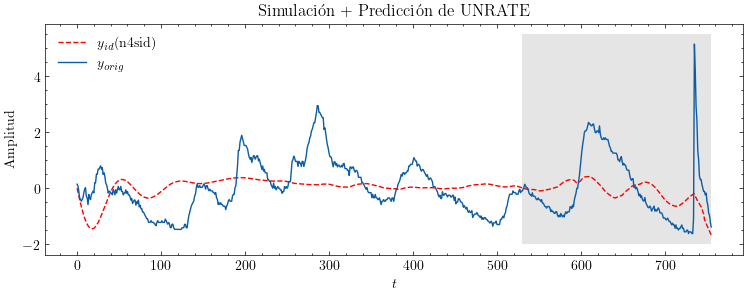

In [43]:
with plt.style.context(['science']):
    plt.figure(figsize=(9,3))
    plt.plot(t,y_n4sid.T,'--',color='r',label='$y_{id}$(n4sid)')
    plt.plot(t,Xs[:,-1],label='$y_{orig}$')
    plt.xlabel('$t$')
    plt.ylabel('Amplitud')
    plt.title('Simulación + Predicción de UNRATE')
    plt.legend()

    ylim = plt.ylim()
    plt.fill_between(t[-ntest:], ylim[0], ylim[1], facecolor='k', alpha=0.1);
    #plt.savefig('var05.png')
    plt.show()

In [44]:
rmse(train.values[:,-1:].T,y_n4sid[:,:-ntest],axis=-1), rmse(Xs[-ntest:,-1:],y_n4sid[:,-ntest:].T)

(array([0.91597355]), array([1.17651816]))

In [45]:
r2_score(train.values[:,-1:],y_n4sid[:,:-ntest].T),r2_score(Xs[-ntest:,-1:],y_n4sid[:,-ntest:].T)

(-0.0638632583071359, 0.07451546802454079)

In [46]:
1-(la.norm(Xs[:-ntest,-1:]-y_n4sid[:,:-ntest].T))/la.norm(Xs[:-ntest,-1:]-np.mean(Xs[:-ntest,-1:])),1-(la.norm(Xs[-ntest:,-1:]-y_n4sid[:,-ntest:].T))/la.norm(Xs[-ntest:,-1:]-np.mean(Xs[-ntest:,-1:]))

(-0.03143747183585277, 0.037978933715347774)

In [47]:
sparsity_ss(sys_n4sid_ss)

73.33333333333333

## Autoreg by StatsModels

In [48]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [49]:
model_sm = AutoReg( train.values[:,-1:], 2 , exog = train.values[:,:-1] ,trend='n')

In [50]:
res = model_sm.fit()

In [51]:
x_sm=res.params

In [52]:
x_sm=x_sm.reshape(1,len(x_sm))

In [53]:
x_sm

array([[ 0.93366662, -0.00241071,  0.01016155,  0.28418692, -0.18352161,
         0.03993565, -0.04854071, -0.00609278,  0.08037045, -0.36682268]])

In [56]:
y_sm = Ar_IO_sim(x_sm[:,:2],x_sm[:,2:],train.values[:2,-1:],Xs[:,:-1].T,len(data)-1)

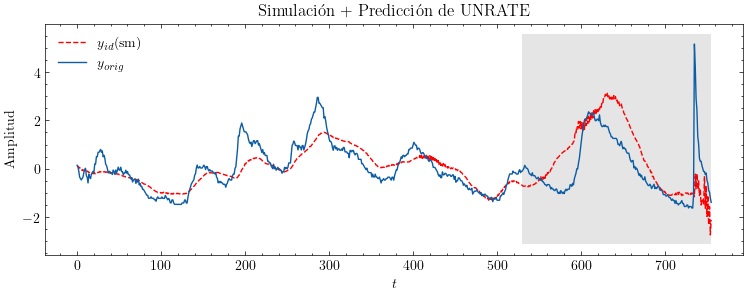

In [57]:
with plt.style.context(['science']):
    plt.figure(figsize=(9,3))
    plt.plot(t,y_sm.T,'--',color='r',label='$y_{id}$(sm)')
    plt.plot(t,Xs[:,-1],label='$y_{orig}$')
    plt.xlabel('$t$')
    plt.ylabel('Amplitud')
    plt.title('Simulación + Predicción de UNRATE')
    plt.legend()

    ylim = plt.ylim()
    plt.fill_between(t[-ntest:], ylim[0], ylim[1], facecolor='k', alpha=0.1);
    #plt.savefig('var06.png')
    plt.show()

In [58]:
r2_score(Xs[:-ntest,-1],y_sm[:,:-ntest].T),r2_score(Xs[-ntest:,-1],y_sm[:,-ntest:].T)

(0.6935553783954443, 0.08411943694688928)

In [59]:
rmse(Xs[:-ntest,-1].T,y_sm[:,:-ntest],axis=-1),rmse(Xs[-ntest:,-1].T,y_sm[:,-ntest:],axis=-1)

(array([0.4916047]), array([1.17039773]))

In [60]:
1-(la.norm(Xs[:-ntest,-1:]-y_sm[:,:-ntest].T))/la.norm(Xs[:-ntest,-1:]-np.mean(Xs[:-ntest,-1:])),1-(la.norm(Xs[-ntest:,-1:]-y_sm[:,-ntest:].T))/la.norm(Xs[-ntest:,-1:]-np.mean(Xs[-ntest:,-1:]))

(0.4464255952407522, 0.042983509518717544)